In [1]:
import pandas as pd
import numpy as np


library_df = pd.read_csv("../Datasets/Merged_Data/merged_data.csv")

final_features = [
    "UNEMPLOYMENT_RATE", "MEDIAN_INCOME", "BACHELORS_PERCENT", "TOTCIR", "F_TOTCIR", 
    "VISITS", "F_VISITS", "REGBOR", "F_REGBOR", "GPTERMS", "F_GPTERM", "TOTSTAFF", 
    "F_TOTSTF", "HRS_OPEN", "F_HRS_OP", "TOTPRO", "F_TOTPRO", "TOTATTEN", "F_TOTATT", 
    "TOTINCM", "F_TOTINC", "TOTOPEXP", "F_TOTOPX", "POPU_UND"
    ]

# Create a copy of the dataframe
analysis_df = library_df.loc[:, final_features].copy()

# Data Preprocessing

In [2]:
# Step 1a: Replace the sentinel for missing income
analysis_df["MEDIAN_INCOME"] = analysis_df["MEDIAN_INCOME"].replace(-666666666.0, np.nan)

# Step 1b: Treat zeros in the other three features as missing
for col in ["BACHELORS_PERCENT", "UNEMPLOYMENT_RATE"]:
    analysis_df[col] = analysis_df[col].replace(0.0, np.nan)


In [3]:
feature_to_flag = {
    "TOTCIR": "F_TOTCIR",
    "VISITS": "F_VISITS",
    "HRS_OPEN": "F_HRS_OP",
    "GPTERMS": "F_GPTERM",
    "TOTATTEN": "F_TOTATT",
    "REGBOR": "F_REGBOR",
    "TOTPRO": "F_TOTPRO",
    "TOTSTAFF": "F_TOTSTF",
    "TOTINCM": "F_TOTINC",
    "TOTOPEXP": "F_TOTOPX"
}

drop_flags = ['U_22', 'H_22', 'L_22']

In [4]:
# Step 2: Convert 0, -1, -3 and -9 into NaN for each feature
for feat in feature_to_flag:
    if feat in analysis_df:
        analysis_df[feat] = analysis_df[feat].replace([0, -1, -3], np.nan)

analysis_df["POPU_UND"] = analysis_df["POPU_UND"].replace([0, -1, -3, -9], np.nan)

In [5]:
# Step 3: Drop rows with NaN POPU_UND values
analysis_df = analysis_df[analysis_df["POPU_UND"].notna()]

In [6]:
# Step 3: Null‑out values whose flag indicates suppression/unusable data
for feat, flag in feature_to_flag.items():
    if flag in analysis_df.columns:
        mask = analysis_df[flag].isin(drop_flags)
        analysis_df.loc[mask, feat] = np.nan

In [7]:
# Step 4: Create binary “_imputed” indicator columns
for feat, flag in feature_to_flag.items():
    if flag in analysis_df.columns:
        analysis_df[f"{feat}_IMPUTED"] = analysis_df[flag].str.startswith("I")

In [8]:
# Step 5: Drop the original F_* flag columns
analysis_df.drop(columns=list(feature_to_flag.values()), inplace=True)

In [9]:
from sklearn.impute import KNNImputer

# Step 6a: List all columns to feed into the imputer:
numeric_cols = list(feature_to_flag.keys()) + ["MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE"]

# Step 6b: Instantiate and apply KNNImputer
knn = KNNImputer(n_neighbors=5)
analysis_df[numeric_cols] = knn.fit_transform(analysis_df[numeric_cols])


# Feature Engineering

In [11]:
# Per-Capita Metrics
analysis_df["CHECKOUTS_PER_CAPITA"] = analysis_df["TOTCIR"] / analysis_df["POPU_UND"]
analysis_df["ATTENDANCE_PER_CAPITA"] = analysis_df["TOTATTEN"] / analysis_df["POPU_UND"]
analysis_df["VISITS_PER_CAPITA"] = analysis_df["VISITS"] / analysis_df["POPU_UND"]


derived_feature_map = {
    "CHECKOUTS_PER_CAPITA": "TOTCIR",
    "VISITS_PER_CAPITA": "VISITS",
    "ATTENDANCE_PER_CAPITA": "TOTATTEN",
}


# Rename the *_IMPUTED columns according to the derived features
for new_col, original_col in derived_feature_map.items():
    imputed_col = f"{original_col}_IMPUTED"
    if imputed_col in analysis_df.columns:
        analysis_df.rename(columns={imputed_col: f"{new_col}_IMPUTED"}, inplace=True)

# Drop redundant features
analysis_df.drop(columns=["TOTCIR", "VISITS", "TOTATTEN"], inplace=True)

print(analysis_df.columns.tolist())
    

['UNEMPLOYMENT_RATE', 'MEDIAN_INCOME', 'BACHELORS_PERCENT', 'REGBOR', 'GPTERMS', 'TOTSTAFF', 'HRS_OPEN', 'TOTPRO', 'TOTINCM', 'TOTOPEXP', 'POPU_UND', 'CHECKOUTS_PER_CAPITA_IMPUTED', 'VISITS_PER_CAPITA_IMPUTED', 'HRS_OPEN_IMPUTED', 'GPTERMS_IMPUTED', 'ATTENDANCE_PER_CAPITA_IMPUTED', 'REGBOR_IMPUTED', 'TOTPRO_IMPUTED', 'TOTSTAFF_IMPUTED', 'TOTINCM_IMPUTED', 'TOTOPEXP_IMPUTED', 'CHECKOUTS_PER_CAPITA', 'ATTENDANCE_PER_CAPITA', 'VISITS_PER_CAPITA']


# Exploratory Data Analysis (EDA)

In [12]:
# Data shape and types
print("Shape:", analysis_df.shape)
print("\nDtypes:\n", analysis_df.dtypes)

Shape: (9160, 24)

Dtypes:
 UNEMPLOYMENT_RATE                float64
MEDIAN_INCOME                    float64
BACHELORS_PERCENT                float64
REGBOR                           float64
GPTERMS                          float64
TOTSTAFF                         float64
HRS_OPEN                         float64
TOTPRO                           float64
TOTINCM                          float64
TOTOPEXP                         float64
POPU_UND                         float64
CHECKOUTS_PER_CAPITA_IMPUTED        bool
VISITS_PER_CAPITA_IMPUTED           bool
HRS_OPEN_IMPUTED                    bool
GPTERMS_IMPUTED                     bool
ATTENDANCE_PER_CAPITA_IMPUTED       bool
REGBOR_IMPUTED                      bool
TOTPRO_IMPUTED                      bool
TOTSTAFF_IMPUTED                    bool
TOTINCM_IMPUTED                     bool
TOTOPEXP_IMPUTED                    bool
CHECKOUTS_PER_CAPITA             float64
ATTENDANCE_PER_CAPITA            float64
VISITS_PER_CAPITA            

In [13]:
# Head and descriptive stats
display(analysis_df.head())
display(analysis_df.describe().T)

,UNEMPLOYMENT_RATE,MEDIAN_INCOME,BACHELORS_PERCENT,REGBOR,GPTERMS,TOTSTAFF,HRS_OPEN,TOTPRO,TOTINCM,TOTOPEXP,...,GPTERMS_IMPUTED,ATTENDANCE_PER_CAPITA_IMPUTED,REGBOR_IMPUTED,TOTPRO_IMPUTED,TOTSTAFF_IMPUTED,TOTINCM_IMPUTED,TOTOPEXP_IMPUTED,CHECKOUTS_PER_CAPITA,ATTENDANCE_PER_CAPITA,VISITS_PER_CAPITA
0,108.0,58018.0,279.0,1950.0,5.0,0.68,1404.0,150.0,71874.0,66006.0,...,False,False,False,False,False,False,False,4.143130,0.428435,2.446088
1,416.0,72958.0,1832.0,123846.0,161.0,60.00,7596.0,758.0,9357471.0,9181224.0,...,False,False,False,False,False,False,False,3.037981,0.037071,0.902910
2,3.0,111250.0,6.0,138.0,2.2,0.30,420.0,54.6,13885.0,15337.0,...,False,False,True,False,True,False,True,4.352273,3.419318,2.392045
3,363.0,94313.0,376.0,2062.0,8.0,2.50,2040.0,80.0,138115.0,241204.0,...,False,False,False,False,False,False,False,1.584882,0.742576,2.035414
4,566.0,87247.0,1629.0,2867.0,7.0,6.00,2356.0,249.0,417502.0,394686.0,...,False,False,False,False,False,False,False,2.863800,0.870285,2.700359


,count,mean,std,min,25%,50%,75%,max
UNEMPLOYMENT_RATE,9160.0,3.283945e+02,4.486436e+02,1.000000,41.000000,145.500000,4.440000e+02,3.987000e+03
MEDIAN_INCOME,9160.0,7.443555e+04,3.050499e+04,10850.000000,55565.000000,67219.000000,8.524000e+04,2.500010e+05
BACHELORS_PERCENT,9160.0,1.753740e+03,2.412498e+03,1.000000,230.000000,719.000000,2.295250e+03,2.154900e+04
REGBOR,9160.0,1.932996e+04,8.590114e+04,1.000000,994.000000,3082.000000,1.003575e+04,2.863691e+06
GPTERMS,9160.0,3.098074e+01,1.139280e+02,1.000000,5.000000,9.000000,2.100000e+01,3.790000e+03
TOTSTAFF,9160.0,1.620441e+01,5.674656e+01,0.030000,1.500000,4.000000,1.130250e+01,2.197960e+03
HRS_OPEN,9160.0,3.975258e+03,8.434425e+03,12.000000,1641.000000,2270.000000,3.016000e+03,2.122850e+05
TOTPRO,9160.0,3.799200e+02,1.115554e+03,1.000000,55.000000,154.000000,3.720000e+02,6.359800e+04
TOTINCM,9160.0,1.867497e+06,8.307901e+06,236.000000,89928.000000,290712.000000,1.037359e+06,3.517798e+08
TOTOPEXP,9160.0,1.697170e+06,7.647920e+06,378.000000,85297.750000,269010.000000,9.303082e+05,3.319634e+08


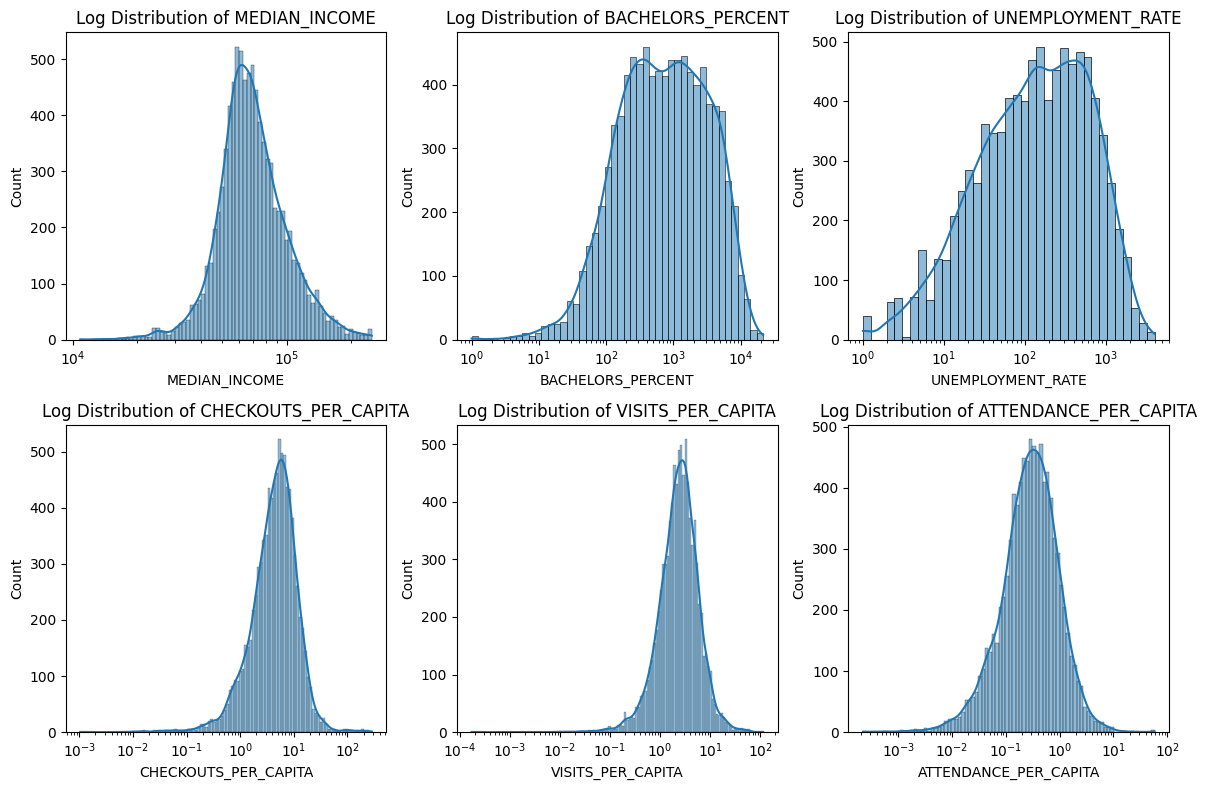

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = [
    "MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE",
    "CHECKOUTS_PER_CAPITA", "VISITS_PER_CAPITA", 
    "ATTENDANCE_PER_CAPITA"
]

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(analysis_df[feature], kde=True, log_scale=True)
    plt.title(f"Log Distribution of {feature}")
plt.tight_layout()
plt.show()

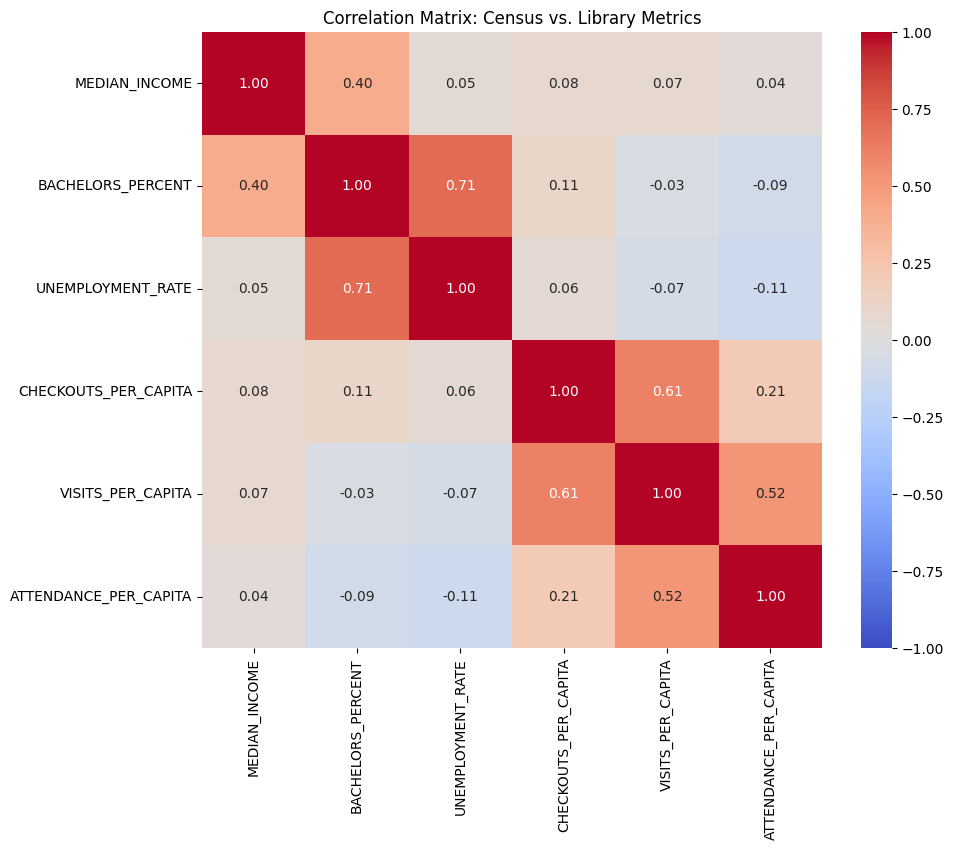

In [21]:
# Correlation matrix (focus on census vs. library metrics)
correlation_features = [
    "MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE",
    "CHECKOUTS_PER_CAPITA", "VISITS_PER_CAPITA", "ATTENDANCE_PER_CAPITA"
]

plt.figure(figsize=(10, 8))
sns.heatmap(
    analysis_df[correlation_features].corr(),
    annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f"
)
plt.title("Correlation Matrix: Census vs. Library Metrics")
plt.show()

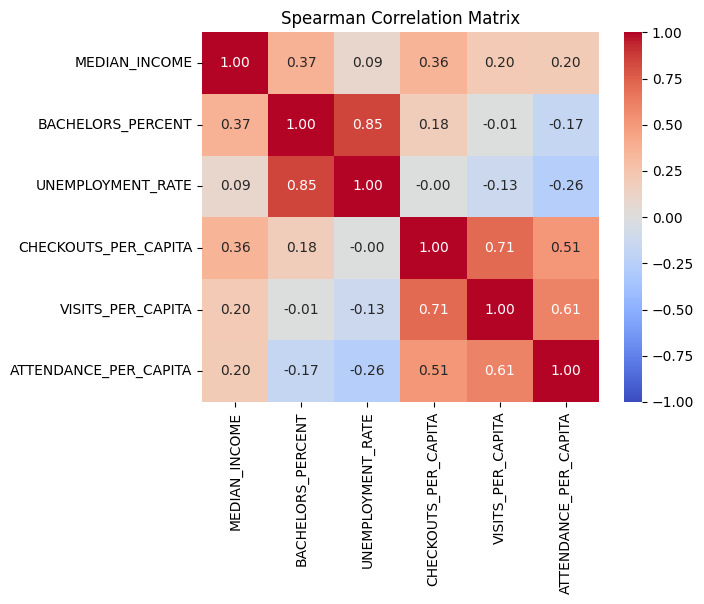

In [22]:
# Compute Spearman correlation
spearman_corr = analysis_df[correlation_features].corr(method="spearman")

# Visualize
sns.heatmap(
    spearman_corr, 
    annot=True, cmap="coolwarm", vmin=-1, vmax=1,
    annot_kws={"size": 10}, fmt=".2f"
)
plt.title("Spearman Correlation Matrix")
plt.show()

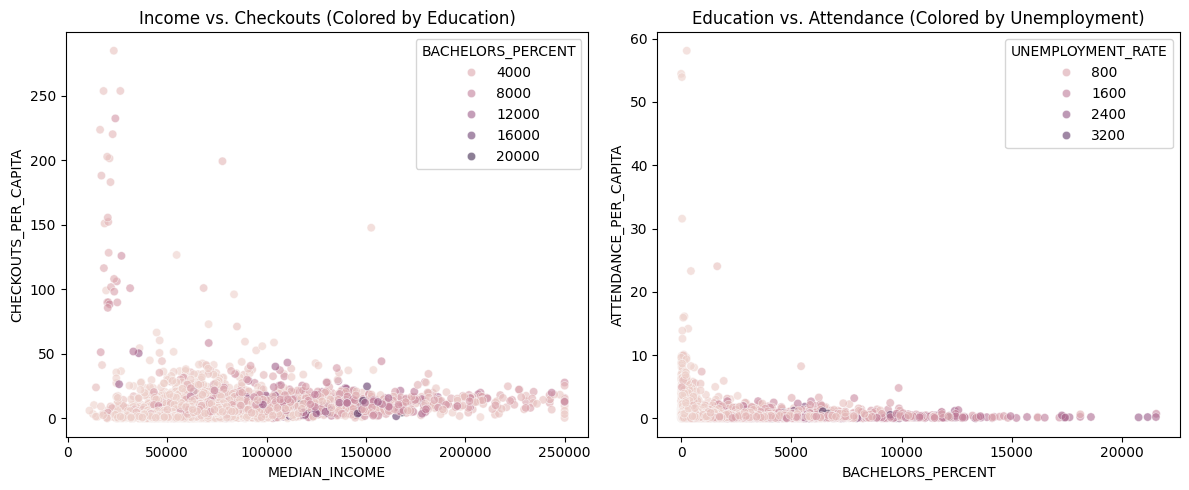

In [17]:
# Scatter plots: Income/Education vs. Checkouts/Attendance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="MEDIAN_INCOME", y="CHECKOUTS_PER_CAPITA",
    hue="BACHELORS_PERCENT", data=analysis_df, alpha=0.6
)
plt.title("Income vs. Checkouts (Colored by Education)")

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="BACHELORS_PERCENT", y="ATTENDANCE_PER_CAPITA",
    hue="UNEMPLOYMENT_RATE", data=analysis_df, alpha=0.6
)
plt.title("Education vs. Attendance (Colored by Unemployment)")
plt.tight_layout()
plt.show()

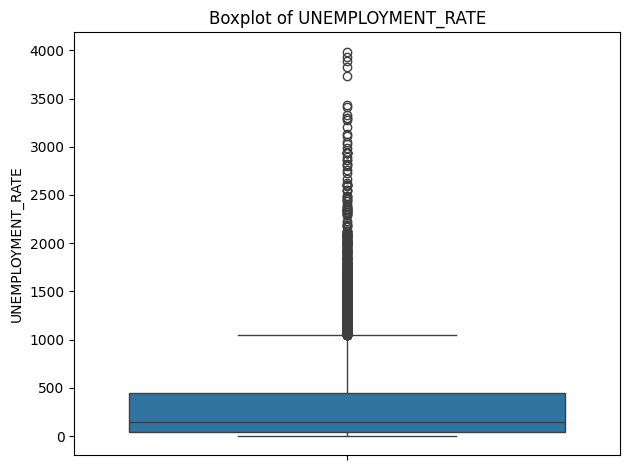

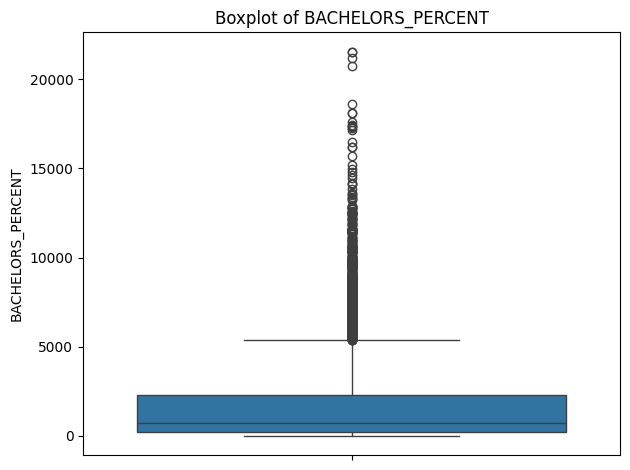

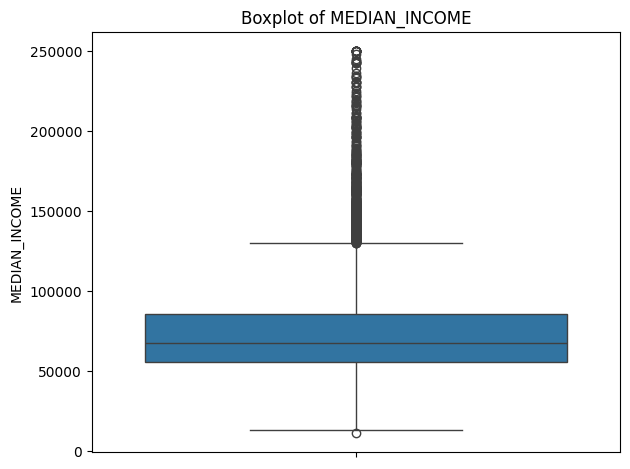

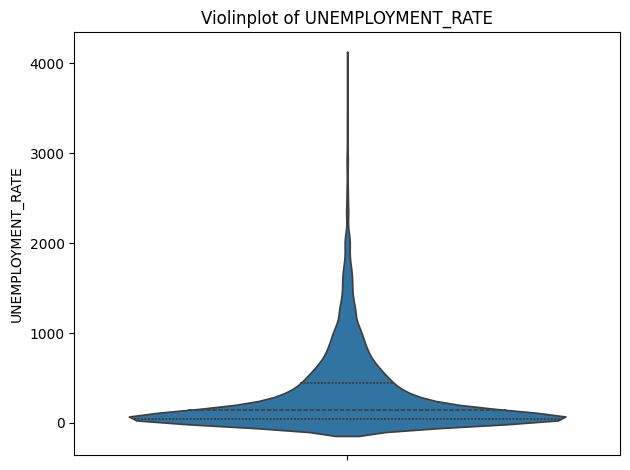

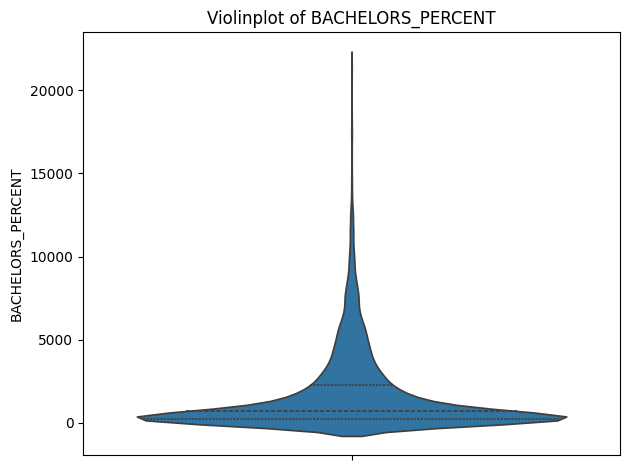

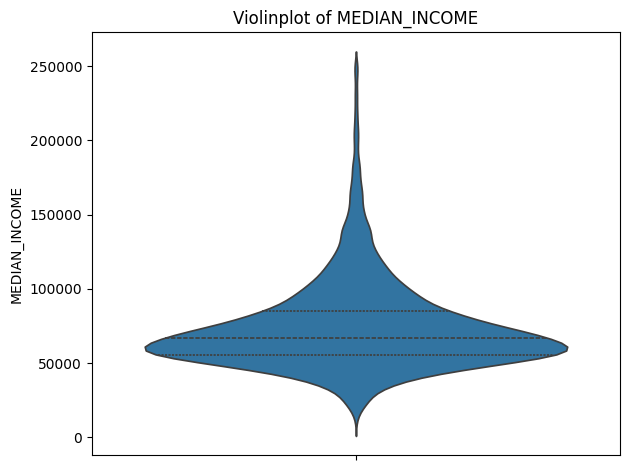

In [24]:

cols = [
    "UNEMPLOYMENT_RATE",
    "BACHELORS_PERCENT",
    "MEDIAN_INCOME"
]

# Boxplots
for col in cols:
    plt.figure()
    sns.boxplot(y=analysis_df[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Violinplots
for col in cols:
    plt.figure()
    sns.violinplot(y=analysis_df[col], inner="quartile")
    plt.title(f"Violinplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Hypothesis Tests